# Отчет по проекту: Изучение поведения пользователей интернет магазина продуктов питания, воронки продаж и влияния изменений интерфейса пользователей на таковые

# Даты выполнения проекта: 05.09.2022 - 15.09.2022

# Цели и задачи проекта
**Цели**:
1. Выяснить, как ведут себя пользователи мобильного приложения интернет магазина.
2. Дать рекомендации по результатам A/A/B тестирования относительно изменений шрифтов. 

**Задачи**:
1. Изучить данные лога событий.
2. Определить параметры воронки продаж.
3. Проанализировать результаты A/A/B тестирования.
4. Сделать выводы об характере поведения пользователей.
5. Дать рекомендации по запуску в коммерческую эксплуатацию протестированных изменений пользовательского интерфейса.

# Исходные данные
Для выполнения задач проекта был предоставлен регистрационный файл (лог) записей релевантных действий пользователей и событий его жизненного цикла, содержащий следующую информацию по каждой записи в нем:
* `EventName      /` после предобработки переименован в `event    —` название события;
* `DeviceIDHash   /` после предобработки переименован в `uid      —` уникальный идентификатор пользователя;
* `EventTimestamp /` после предобработки переименован в `event_dt —` время события;
* `ExpId          /` после предобработки переименован в `group    —` номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Ознакомление с файлом данных

In [1]:
# собираем весь импорт в одном месте

import datetime as dt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import optimize
import math

In [2]:
start_run = dt.datetime.now() # будем измерять время выполнения команды run-all-cells

In [3]:
# считываем датасет в одноименную переменную (применяем try-except, чтобы работало и локально, и на тренажере)
try:
    events_df = pd.read_csv('datasets/logs_exp.csv', sep='\t') # делимитер определяем, открыв файл любым редактором
except:
    events_df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

events_df.info() # смотрим типы
events_df.head(2) # смотрим форматы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


In [4]:
events_df['ExpId'].value_counts(dropna=False) # проверка соответствия ожиданиям

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

In [5]:
events_df['EventName'].value_counts(dropna=False) # проверка соответствия ожиданиям

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

### Выводы по исходным данным:
* Пропусков данных нет;
* Возможны дупликаты;
* Все пользователи принадлежат группам A/A/B тестирования, но возможны фликеры (пользователи сменившие группу);
* Названия типов событий позволяют предположить, что четверо из них соответствуют конверсионным точкам воронки продаж, а пятый может быть создан пользователем в любой момент (Tutorial) - фактически, это обращение к helper-у, и его частота косвенно может свидетельствовать о наличии затруднений у пользователей с интерфейсом приложения.
* **План дальнейшей предобработки данных**:
 * Названия полей требуют упрощения и приведения к нотации Питона;
 * Значение идентификатора группы желательно сделать категорией и более информативным - рекомендуем ('A-246', 'A-247', 'B-248');
 * Время, видимо, имеет формат секунд от "Рождества Unix-ового" - нужен перевод в более привычные для анализа дату и время.

### Формат времени в исходных данных
Проверим гипотезу о формате времени - секунды после 01.01.1970 00:00:00 (epoch).  Воспользуемся сайтом конверсии Unix-времени https://www.unixtimestamp.com/ для первой строки вывода датафрейма выше:

| param          |  | value                                 |
| :---           |--| :---                                  |
| Input Time     |  | 1564029816                            | 
| Input Units    |  | Seconds                               |
| Output GMT	 |  | Thu **Jul 25 2019** 04:43:36 GMT+0000 |


Гипотеза подтвердилась - в данном курсе многие датафреймы были за 2019 год

## Предобработка данных
Следуем плану предобработки выше.
### Оптимизация имен и категорий датасета, приведение типов данных

In [6]:
events_df.columns = ('event_name','uid','event_dt','group')

In [7]:
def line_f_groups(s):
    if s == 246: return 'A-246'
    elif s == 247: return 'A-247'
    elif s == 248: return 'B-248'
    else: return 'NoGroup'

events_df['group'] = events_df['group'].apply(line_f_groups)

In [8]:
events_df['event_dt'] = pd.to_datetime(events_df['event_dt'], unit='s')

In [9]:
events_df.info()
events_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   uid         244126 non-null  int64         
 2   event_dt    244126 non-null  datetime64[ns]
 3   group       244126 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 7.5+ MB


,event_name,uid,event_dt,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A-246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A-246


**Косметические улучшения датасета проведены**:
* нормализованы названия полей датасета,
* машинное время приведено к человеческому формату,
* в имена групп добавлены буквы, означающие роль группы в A/A/B тестировании - для удобства работы,
* имена событий длинные и неудобные, но принято решение их не менять - для простоты представления результатов заказчику, который привык к данным именам.

#### Создание истории датасета `events_df` - в датасете `df_history`
перед тем, как начать удаление дупликатов - записей исходного датасета, инициируем ведение истории размеров датасета

In [10]:
df_history = pd.DataFrame(['initial_input', len(events_df), events_df['uid'].nunique(),
                          events_df.query('group == "A-246"')['uid'].nunique(),
                          events_df.query('group == "A-247"')['uid'].nunique(),
                          events_df.query('group == "B-248"')['uid'].nunique()
                          ]).T
df_history.columns = ('milestone', 'nof_entries', 'nof_users', 'nof_A-246', 'nof_A-247','nof_B-248')
df_history

,milestone,nof_entries,nof_users,nof_A-246,nof_A-247,nof_B-248
0,initial_input,244126,7551,2489,2520,2542


### Проверка дупликатов

In [11]:
print( 'Полных дупликатов', events_df.duplicated().sum(), '(', 
      round(100 * events_df.duplicated().sum() / len(events_df),2), '% от всего датасета)' )

Полных дупликатов 413 ( 0.17 % от всего датасета)


In [12]:
events_df = events_df.drop_duplicates().reset_index(drop=True) # удаляем полные дупликаты

print( 'Дупликатов с разными значениями группы', events_df.drop(columns='group').duplicated().sum() )

Дупликатов с разными значениями группы 0


**Дупликатов больше нет**:
* удалено 413 полных дупликатов (0.17%).

#### Обновление истории выброса данных датасета `events_df`:

In [13]:
new_line = pd.DataFrame(['duplicates_dropped', len(events_df), events_df['uid'].nunique(),
                        events_df.query('group == "A-246"')['uid'].nunique(),
                        events_df.query('group == "A-247"')['uid'].nunique(),
                        events_df.query('group == "B-248"')['uid'].nunique()
                        ]).T
new_line.columns = ('milestone', 'nof_entries', 'nof_users', 'nof_A-246', 'nof_A-247','nof_B-248')
df_history = df_history.append(new_line).reset_index(drop=True)

presentation = df_history.set_index('milestone').T

presentation['last_change_%'] = 10000 * (
                                       presentation[list(presentation.columns)[-1]] - 
                                       presentation[list(presentation.columns)[-2]]
                                      ) / presentation[list(presentation.columns)[-2]]
presentation['last_change_%'] = presentation['last_change_%'].astype('int') / 100

presentation['total_change_%'] = 10000 * (
                                        presentation[list(presentation.columns)[-2]] - 
                                        presentation[list(presentation.columns)[0]]
                                       ) / presentation[list(presentation.columns)[0]]
presentation['total_change_%'] = presentation['total_change_%'].astype('int') / 100

presentation

milestone,initial_input,duplicates_dropped,last_change_%,total_change_%
nof_entries,244126,243713,-0.16,-0.16
nof_users,7551,7551,0.00,0.00
nof_A-246,2489,2489,0.00,0.00
nof_A-247,2520,2520,0.00,0.00
nof_B-248,2542,2542,0.00,0.00


### Проверка фликеров

In [14]:
print()
print('Всего имеем', len(events_df), 'записи в датафрейме,')
print('а уникальных сочетаний (uid, group):', events_df[['uid','group']].value_counts().sum())  

print()
print('ВЫВОД:')
print('_________________________________________________________')
if len(events_df) == events_df[['uid','group']].value_counts().sum():
    print('Фликеров в датасете нет.  Удаление фликеров не требуется.')
else:
    print('В датасете есть фликеры.  Требуется удаление фликеров.')


Всего имеем 243713 записи в датафрейме,
а уникальных сочетаний (uid, group): 243713

ВЫВОД:
_________________________________________________________
Фликеров в датасете нет.  Удаление фликеров не требуется.


### Добавление рабочих полей

#### Добавление поля даты события
Дальнейший анализ посуточных характеристик потребует группировок по дате, поэтому сразу добавим дату в датасет:

In [15]:
events_df['date'] = pd.to_datetime(events_df['event_dt'].dt.date)

### Финальный датасет `events_df` после предобработки

In [16]:
events_df.info()
events_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   uid         243713 non-null  int64         
 2   event_dt    243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


,event_name,uid,event_dt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A-246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A-246,2019-07-25


## Исследовательский анализ данных (EDA)

### События и пользователи

In [17]:
print()
print('ВЫВОДЫ:')
print('__________________________________________________________________________________________________________')
print('Всего в логе присутствует (после удаления дупликатов)', len(events_df), 'инстансов событий, включающих', 
      events_df['event_name'].nunique(), 'типов событий.')

print('Данные события сгенерены действиями', events_df['uid'].nunique(), 'уникальных пользователей.')
print('В среднем на одного пользователя приходится по', round(len(events_df)/events_df['uid'].nunique(),1), 
      'события (его действий, регистрируемых в журнале лога).')


ВЫВОДЫ:
__________________________________________________________________________________________________________
Всего в логе присутствует (после удаления дупликатов) 243713 инстансов событий, включающих 5 типов событий.
Данные события сгенерены действиями 7551 уникальных пользователей.
В среднем на одного пользователя приходится по 32.3 события (его действий, регистрируемых в журнале лога).


### Временные характеристики имеющихся данных

In [18]:
print('Временной период данных охватывает', round((events_df['date'].max() - events_df['date'].min())/dt.timedelta(days=1) + 1),
      'дней, начиная с момента', events_df['event_dt'].min(), 'и заканчивая моментом', events_df['event_dt'].max())
first_day = events_df['date'].min()
last_day = events_df['date'].max()

Временной период данных охватывает 14 дней, начиная с момента 2019-07-25 04:43:36 и заканчивая моментом 2019-08-07 21:15:17


### Гистограммы распределения событий во времени

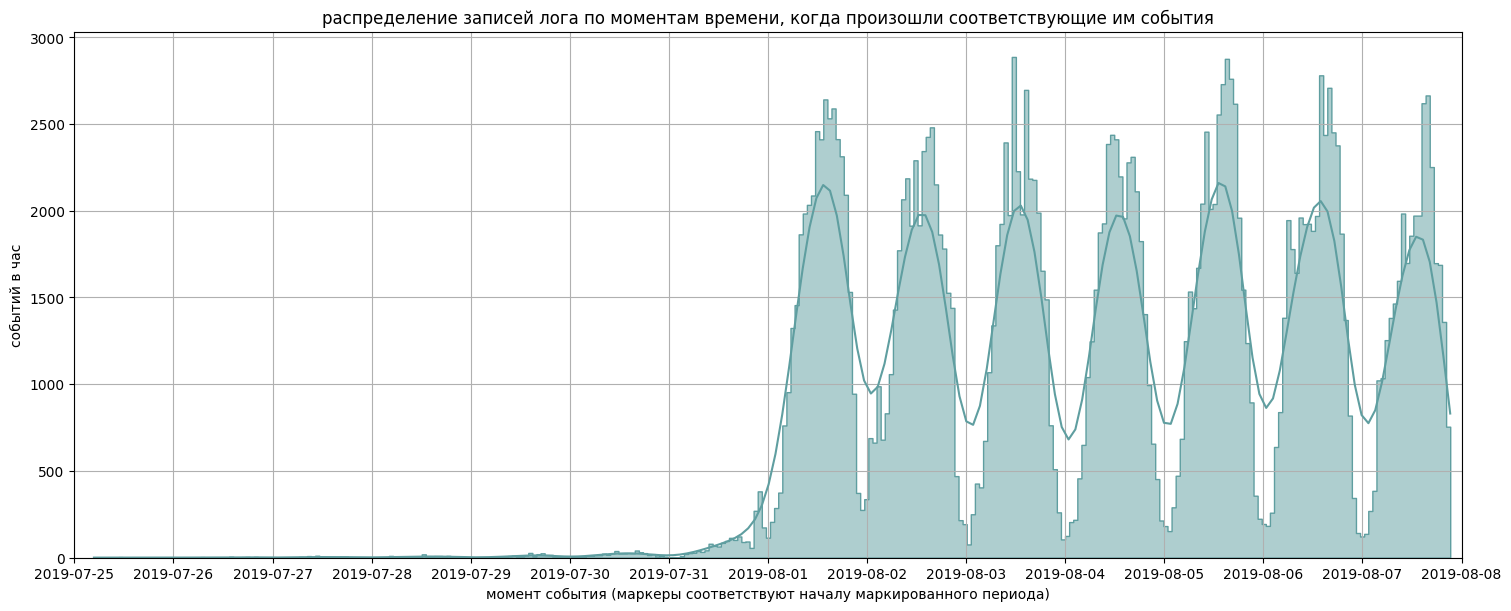

In [19]:
my_bins = 21+12*24+22 # будем смотреть почасовое распределение

plt.figure(figsize=(15, 6), constrained_layout=True)

sns.histplot(data=events_df, x='event_dt', element='step', kde=True, color='cadetblue', bins=my_bins )


plt.xlabel('момент события (маркеры соответствуют началу маркированного периода)')
plt.ylabel('событий в час')
plt.xlim(left=dt.datetime(2019,7,25), right=dt.datetime(2019,8,8))
plt.xticks( ticks=[dt.datetime(2019,7,25)+dt.timedelta(days=1)*d for d in range(15)] )
plt.grid()

plt.title("распределение записей лога по моментам времени, когда произошли соответствующие им события") 
plt.show()

**Анализ графика**:  очень странное распределение - предлагаемый комментарий в инструкции по проекту "***Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные»***" никак не объясняет данный график:
* задержка записи в логи должна была бы привести к отсутствию событий последних часов или минут в логе (записи еще "не доехали"), но никак не может "перекосить" момент, когда произошло само событие; 
* если только у нас timestamp не проставлялся самой системой лога, а не датчиком (обычно, сниффером) регистрации события - но тогда такие данные вообще испорчены для временного анализа (временной лаг может "плавать", и в этом случае последовательность событий от одного пользователя может быть нарушена).

Посмотрим меняется ли картина для разных видов событий:

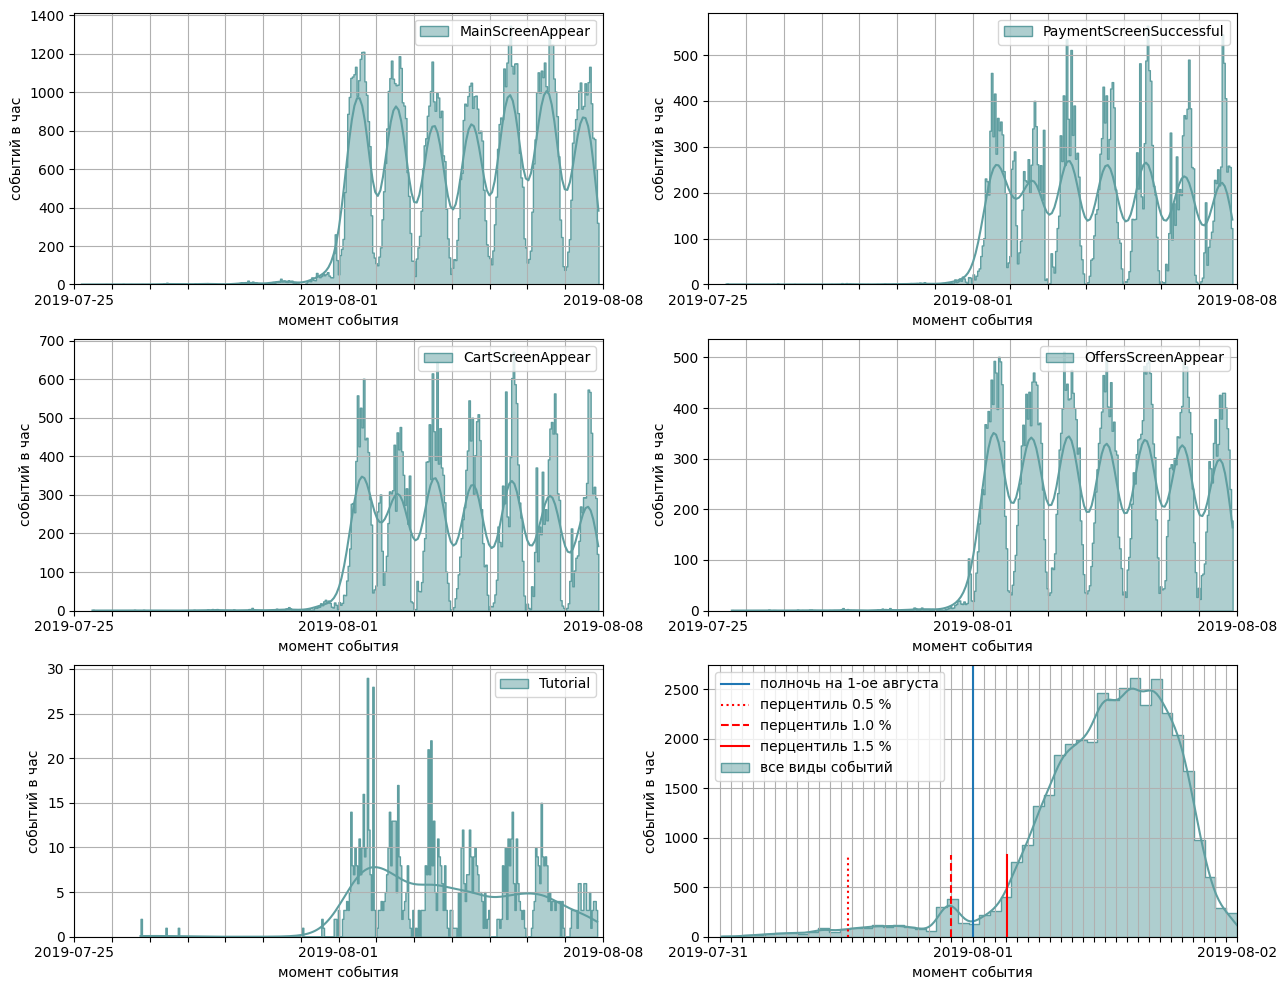

In [20]:
my_bins = 21+12*24+22 # будем смотреть почасовое распределение 

plt.figure(figsize=(15, 12))

myax = [plt.subplot(3,2,1+i) for i in range(6)]

fr = 0
for event_type in list(events_df['event_name'].unique()):
    sns.histplot(data=events_df.query('event_name == @event_type'), 
                 x='event_dt', element='step', kde=True, color='cadetblue', ax=myax[fr], bins=my_bins, label=event_type )

    myax[fr].set_xlabel('момент события')
    myax[fr].set_ylabel('событий в час')
    myax[fr].set_xlim(left=dt.datetime(2019,7,25), right=dt.datetime(2019,8,8))
    myax[fr].set_xticks([dt.datetime(2019,7,25)+dt.timedelta(days=1)*d for d in range(15)])
    myax[fr].set_xticklabels(['2019-07-25']+6*[' ']+['2019-08-01']+6*[' ']+['2019-08-08'])
    myax[fr].legend()
    myax[fr].grid()
    fr += 1

# сделаем zoom на окрестности точки изменения характера в ночь на 2019-08-01:

sns.histplot(data=events_df.query('@dt.datetime(2019,7,31) < event_dt < @dt.datetime(2019,8,2)'), 
                 x='event_dt', element='step', kde=True, color='cadetblue', ax=myax[5], bins=48, 
                label='все виды событий' )

myax[5].set_xlabel('момент события')
myax[5].set_ylabel('событий в час')
myax[5].set_xlim(left=dt.datetime(2019,7,31), right=dt.datetime(2019,8,2))
myax[5].set_xticks([dt.datetime(2019,7,31)+dt.timedelta(hours=1)*h for h in range(49)])
myax[5].set_xticklabels(['2019-07-31']+23*[' ']+['2019-08-01']+23*[' ']+['2019-08-02'])

myax[5].axvline(x=dt.datetime(2019,8,1), label= 'полночь на 1-ое августа')
myax[5].axvline(x=np.percentile(events_df['event_dt'],0.5), 
                ymin=0, ymax=0.3, color='red', label= 'перцентиль 0.5 %', linestyle=':')
myax[5].axvline(x=np.percentile(events_df['event_dt'],1.0), 
                ymin=0, ymax=0.3, color='red', label= 'перцентиль 1.0 %', linestyle='--')
myax[5].axvline(x=np.percentile(events_df['event_dt'],1.5), 
                ymin=0, ymax=0.3, color='red', label= 'перцентиль 1.5 %')

myax[5].legend()
myax[5].grid()
    
plt.show()

**Анализ графика**: аномалия распределения событий в первую неделю видна для всех типов событий - предлагаемый комментарий в инструкции по проекту "Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные»" ее также никак не объясняет.

#### Выводы по гистограммам:
1. По каким-то причинам данные за первую неделю испорчены и не вызывают доверия, поэтому их желательно убрать из анализа.
2. Распределения показывают, что данных за первую неделю практически нет - по сравнению со второй, поэтому можно ожидать, что при удалении первой недели мы не сильно исказим наш датасет.
3. На основе графика с zoom и процентилей принято решение оставить для дальнейшего анализа данные, начиная с момента 2019-08-01 00:00:00, при этом оцениваемая потеря записей датасета лежит между 1% и 1.5% - и является предварительно допустимой.
 * Окончательный вывод о допустимости таких изменений будет сделан ниже прианализе влияния на состав групп A/A/B тестирования.
4. **NB!**: В итоге у нас вдвое сократился временной интервал анализа - до 7 неполных дней (последний день обрывается в 21:15:17).

### Датасет `events_df` после удаления испорченных данных за первую неделю

In [21]:
events_df = events_df.query('event_dt >= @dt.datetime(2019,8,1)') # делаем срез датасета

events_df.info()
events_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   uid         240887 non-null  int64         
 2   event_dt    240887 non-null  datetime64[ns]
 3   group       240887 non-null  object        
 4   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 11.0+ MB


,event_name,uid,event_dt,group,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,A-246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A-246,2019-08-01


#### Обновление истории выброса данных датасета `events_df` - финальный датасет `df_history`:

In [22]:
new_line = pd.DataFrame(['1st_week_dropped', len(events_df), events_df['uid'].nunique(),
                        events_df.query('group == "A-246"')['uid'].nunique(),
                        events_df.query('group == "A-247"')['uid'].nunique(),
                        events_df.query('group == "B-248"')['uid'].nunique()
                        ]).T
new_line.columns = ('milestone', 'nof_entries', 'nof_users', 'nof_A-246', 'nof_A-247','nof_B-248')
df_history = df_history.append(new_line).reset_index(drop=True)

presentation = df_history.set_index('milestone').T

presentation['last_change_%'] = 10000 * (
                                       presentation[list(presentation.columns)[-1]] - 
                                       presentation[list(presentation.columns)[-2]]
                                      ) / presentation[list(presentation.columns)[-2]]
presentation['last_change_%'] = presentation['last_change_%'].astype('int') / 100

presentation['total_change_%'] = 10000 * (
                                        presentation[list(presentation.columns)[-2]] - 
                                        presentation[list(presentation.columns)[0]]
                                       ) / presentation[list(presentation.columns)[0]]
presentation['total_change_%'] = presentation['total_change_%'].astype('int') / 100

print('история удаления данных исходного датасета events_df:')
print('-----------------------------------------------------')
presentation

история удаления данных исходного датасета events_df:
-----------------------------------------------------


milestone,initial_input,duplicates_dropped,1st_week_dropped,last_change_%,total_change_%
nof_entries,244126,243713,240887,-1.15,-1.32
nof_users,7551,7551,7534,-0.22,-0.22
nof_A-246,2489,2489,2484,-0.20,-0.20
nof_A-247,2520,2520,2513,-0.27,-0.27
nof_B-248,2542,2542,2537,-0.19,-0.19


#### Выводы по изменению датасета исходных данных `events_df`:
1. Потери записей датасета в допустимом диапазоне 1.5 %.
2. Потери в группах A/A/B тестирования в допустимом диапазоне 0.3%.
3. Из двух А-групп самые близкие потери к потерям группы В у группы А-246.  Можно считать, что А-246 лучше сохранила условие изначального равенства групп А и В, чем A-247.  Однако изначально именно А-247 была ближе по кол-ву участников к группе В, и это сохранилось и после удаления данных первой недели.

## Изучение воронки продаж

### Частота событий разных типов - создание датасета `event_types_df`
Будем собирать все ответы в одну таблицу:

In [23]:
# создаем датасет с таблицей для визуализации:
event_types_df = events_df['event_name'].value_counts(dropna=False).reset_index()
event_types_df.columns = ('event_name','nof_event_types')

# расчитываем среднюю частоту событий:
event_types_df['first_dt'] = pd.Series(
    [events_df.query('event_name == @type')['event_dt'].min() for type in list(event_types_df['event_name'])])
event_types_df['last_dt'] = pd.Series(
    [events_df.query('event_name == @type')['event_dt'].max() for type in list(event_types_df['event_name'])])
event_types_df['duration_hours'] = (event_types_df['last_dt'] - event_types_df['first_dt']) / dt.timedelta(hours=1)
event_types_df['avg_frequency_per_hour'] = round((event_types_df['nof_event_types'] - 1) / event_types_df['duration_hours'], 1)

# Удаляем вспомогательные поля:
event_types_df = event_types_df.drop(columns=['first_dt','last_dt','duration_hours'])

# Смотрим ответ на тему главы:
event_types_df

,event_name,nof_event_types,avg_frequency_per_hour
0,MainScreenAppear,117328,710.6
1,OffersScreenAppear,46333,280.6
2,CartScreenAppear,42303,256.6
3,PaymentScreenSuccessful,33918,205.7
4,Tutorial,1005,6.1


### Пользователи, действия которых генерируют события
Продолжим заполнять ответами ту же таблицу:

In [24]:
event_types_df['nof_users'] = pd.Series(
    [events_df.query('event_name == @type')['uid'].nunique() for type in list(event_types_df['event_name'])])
event_types_df['share_of_total_users_%'] = round( event_types_df['nof_users'] / events_df['uid'].nunique() * 100, 2)
event_types_df['avg_events_per_user'] = round(event_types_df['nof_event_types'] / event_types_df['nof_users'], 2)

event_types_df.sort_values('nof_users', ascending=False)

,event_name,nof_event_types,avg_frequency_per_hour,nof_users,share_of_total_users_%,avg_events_per_user
0,MainScreenAppear,117328,710.6,7419,98.47,15.81
1,OffersScreenAppear,46333,280.6,4593,60.96,10.09
2,CartScreenAppear,42303,256.6,3734,49.56,11.33
3,PaymentScreenSuccessful,33918,205.7,3539,46.97,9.58
4,Tutorial,1005,6.1,840,11.15,1.20


Добавим снизу строку для всех видов событий:

In [25]:
event_types_df = event_types_df.append(
    pd.DataFrame(
        {
            'event_name':['AnyFromTheAboveListed'],
            'nof_event_types':[len(events_df)],
            'avg_frequency_per_hour': [round(len(events_df) / ((events_df['event_dt'].max() - events_df['event_dt'].min()
                                                         ) / dt.timedelta(hours=1) ), 1)],
            'nof_users':[events_df['uid'].nunique()],
            'share_of_total_users_%': [100.00],
            'avg_events_per_user': [round(len(events_df) / events_df['uid'].nunique(), 2)]
        }
    )
).reset_index(drop=True)

event_types_df

,event_name,nof_event_types,avg_frequency_per_hour,nof_users,share_of_total_users_%,avg_events_per_user
0,MainScreenAppear,117328,710.6,7419,98.47,15.81
1,OffersScreenAppear,46333,280.6,4593,60.96,10.09
2,CartScreenAppear,42303,256.6,3734,49.56,11.33
3,PaymentScreenSuccessful,33918,205.7,3539,46.97,9.58
4,Tutorial,1005,6.1,840,11.15,1.20
5,AnyFromTheAboveListed,240887,1458.8,7534,100.00,31.97


#### Распределение пользователей по количеству генерируемых ими событий

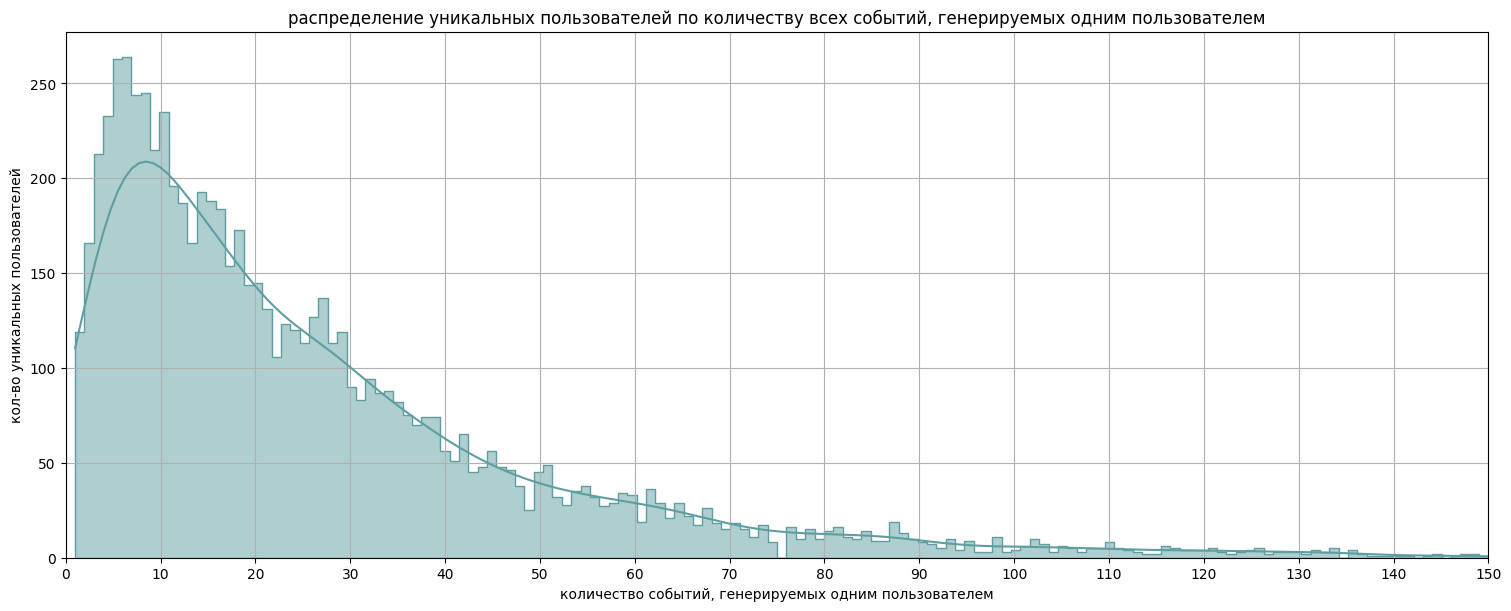

In [26]:
my_bins = 150+1 # будем смотреть распределение со значением для каждого кол-ва событий

plt.figure(figsize=(15, 6), constrained_layout=True)

sns.histplot(data=events_df.groupby('uid').agg({'date':'count'}).rename(columns={'date':'nof_events'}).query(
             'nof_events < @my_bins'), x='nof_events', element='step', kde=True, color='cadetblue', bins=my_bins )

plt.xlabel('количество событий, генерируемых одним пользователем')
plt.ylabel('кол-во уникальных пользователей')
plt.xlim(left=0, right=my_bins-1)
plt.xticks( ticks=[10*i for i in range(16)] )
plt.grid()

plt.title("распределение уникальных пользователей по количеству всех событий, генерируемых одним пользователем") 
plt.show()

### Определение порядка событий в цикле покупки
Наши события относятся к интернет магазину продуктов питания. Поэтому мы можем ожидать, опираясь на собственный опят, примерно следующей модели поведения пользователя (нумерация в порядке логического следования):
1. Принятие решения, что "пора купить продукты" - не регистрируется в логе.
2. Открытия страницы магазина - видимо, соответствует событию `MainScreenAppear`.
3. Выбор продуктов и их количеств - *может* соответствовать событию `OffersScreenAppear` (но есть и второй кандидат - см. ниже).
4. Переход в корзину и ее редактирование - видимо, соответствует событию `CartScreenAppear`.
5. Оформление и оплата заказа - видимо, соответствует событию `PaymentScreenSuccessful`.

В любой промежуточный момент также возможны следующие действия:
* Справка по функционалу (helper, tutorial) - видимо, соответствует событию `Tutorial`.
* Инициируемое магазином льготное предложение и/или показ рекламы "также с этим покупают" - *может* соответствовать событию `OfferScreenAppear` (но есть и первый кандидат - см. выше).

Мы можем собрать датафрейм, состоящий из уникальных пользователей и со столбцом, включающим последовательность событий в порядке их свершения для каждого пользователя - чтобы потом проанализировать наиболее часто встречающуюся последовательность событий, генерируемых пользователем:

#### Создание датасета `users_df`

In [27]:
uid_list = list(events_df['uid'].unique()) # зафиксируем произвольную последовательность уникальных uid из исходного датасета

# а вот выполнение этой строки кода займет почти полминуты, так как ему нужно 7.5К раз просмотреть 241К строк!:
events_list = [list(events_df.query('uid == @user').sort_values('event_dt')['event_name']) for user in uid_list]

users_df = pd.DataFrame(data={ 'uid':uid_list, 'time_sorted_events': events_list })

# добавим группу
users_df = users_df.merge(events_df.groupby('uid',as_index=False).agg({'group':'first'}), how='left', on='uid')

#### Алгоритм нахождения порядкового номера события для одного пользователя
Итак в датафрейме `users_df` каждому пользователю соответствует непустой$^{*)}$ список его действий, упорядоченный во временном порядке.  Предлагается определять порядок следования по первой встрече события в списке.  Такой метод имеет два ограничения:
1. Для большинства пользователей мы видим количество действий в несколько раз превышающее количество типов, скорее всего такие пользователи по нескольку раз повторяют весь цикл.  Но в нашем методе мы получим последовательность только в первом полном цикле.
2. Именно первый цикл начинается в произвольный момент цикла - из-за обрезания данных по времени, поэтому наша последовательность может хаотично начинаться с любого момента цикла .

Данные ограничения смажут нашу картину, но мы надеемся все же увидеть наиболее вероятные места для каждого типа события в общем цикле.  Если данного подхода окажется недостаточно, попробуем усилить анализ учетом вторых циклов.

В пользу данного метода может сыграть тот факт, что мы обрезали данные слева ровно в полночь, когда активность пользователей минимальна (хорошо видно по графикам распределений запросов по времени).  Поэтому можно ожидать, что в данный момент покупателей, оформляющих покупку продуктов статистически мало.  А вернувшееся утром большинство покупателей начнет обычный цикл покупки с начала цикла.

* *) он всегда непустой, так как пользователи не совершившие действия просто отсутствуют в `events_df`  

In [28]:
def line_f_position(l,type):
    if type not in l: return np.NaN
    else: return len(set(l[:l.index(type)]))+1

for name in list(events_df['event_name'].unique()):
    users_df[name] = users_df['time_sorted_events'].apply(line_f_position, type=name) 
    # просто считаем число других типов перед первой встречей нужного нам типа (и добавляем единицу)

users_df.head() # проверим визуально результат

,uid,time_sorted_events,group,Tutorial,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
0,3737462046622621720,"[Tutorial, MainScreenAppear, MainScreenAppear,...",A-246,1.0,2.0,3.0,4.0,5.0
1,1433840883824088890,"[MainScreenAppear, MainScreenAppear, MainScree...",A-247,NaN,1.0,NaN,NaN,NaN
2,4899590676214355127,"[MainScreenAppear, MainScreenAppear, OffersScr...",A-247,NaN,1.0,2.0,3.0,4.0
3,1182179323890311443,"[MainScreenAppear, MainScreenAppear, MainScree...",A-246,NaN,1.0,NaN,NaN,NaN
4,4613461174774205834,"[MainScreenAppear, MainScreenAppear, CartScree...",B-248,NaN,1.0,4.0,2.0,3.0



                        распределения событий по порядку их появления в логе для одного и того же пользователя


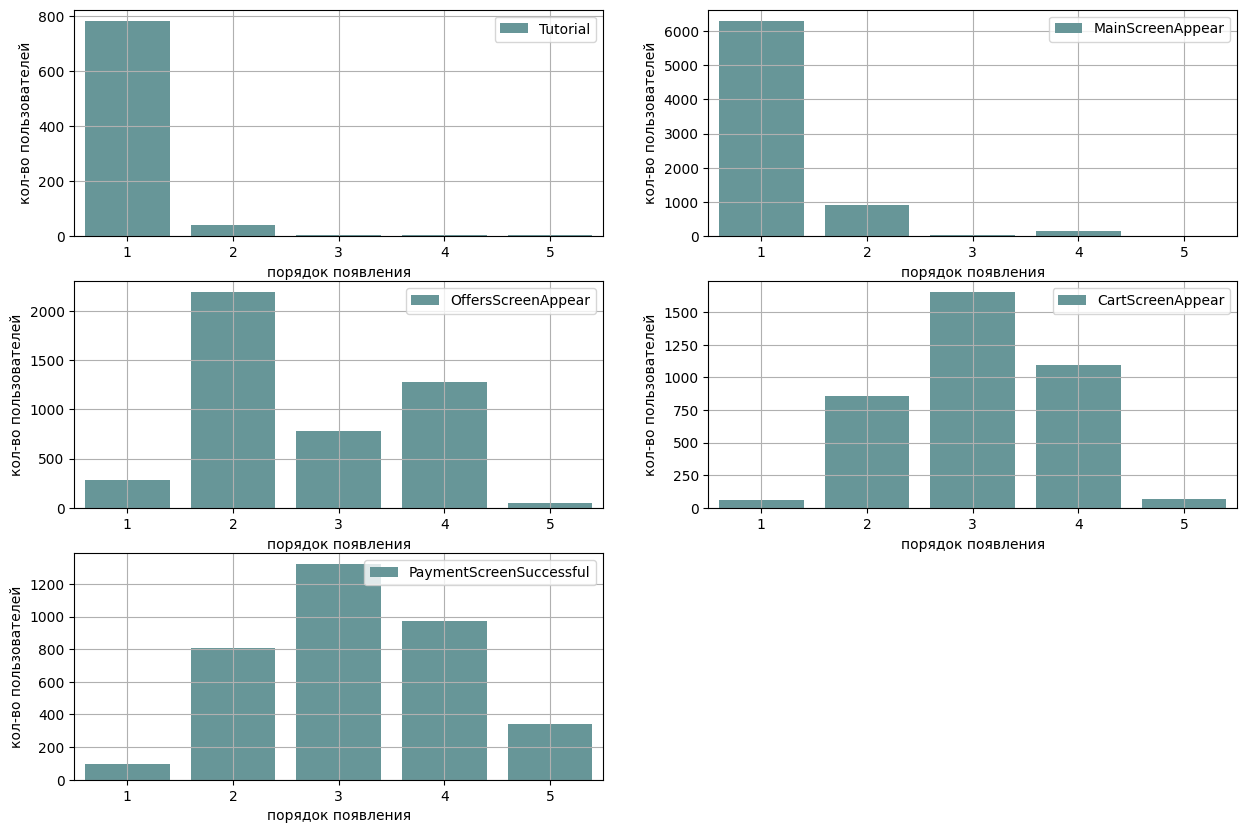

In [29]:
types_list = list(events_df['event_name'].unique()) # зафиксируем список

print()
print('                        распределения событий по порядку их появления в логе для одного и того же пользователя')

plt.figure(figsize=(15, 10))

myax = [plt.subplot(3,2,1+i) for i in range(5)]

for i in range(5):
    sns.countplot(data=users_df, x=types_list[i], order=[1,2,3,4,5], color='cadetblue', ax=myax[i], label=types_list[i] )

    myax[i].set_xlabel('порядок появления')
    myax[i].set_ylabel('кол-во пользователей')
    myax[i].legend()
    myax[i].grid()

plt.show()

**Анализ графика**:
1. Первая позиция и у *Tutorial*, и у *MainScreenAppear*, причем у *Tutorial* преференции на первое место выражены гораздо четче.  Мы помним по результатам выше, что к *Tutorial* обращается только 11% пользователей.  Для них места остальных собитий просто смещаются на +1.  Таким образом, *Tutorial* является опционным первым шагом и чтобы избежать его влияния на определение порядка остальных шагов, лучше повторить данные графики,уже без учета событий *Tutorial*.
2. Вторая позиция также еще хорошо видна у *OffersScreenAppear* 
3. А вот третью позицию уже трудно определить - она одинаково проявлена и у *CartScreenAppear* и у *PaymentScreenSuccessful*, попробуем снова - без *Tutorial*.

С точки зрения кода, самое простое повторить сборку датасета `users_df` - на этот раз используя срез `events_df` без *Tutorial*.  Но это занимает много времени на выполнение, так как количество операций по сборке поля со списком событий для одного пользователя порядка $7500*N$, где $N$ - размер датасета.  Лучше применим построчную функцию, которая удалит *Tutorial* из поля со списком событий для одного пользователя - в этом случае мы попадаем только на $N$ операций со списком средней длины в несколько десятков элементов (ожидается, что выполняться будет раз в 50 быстрее - вместо минуты будет секунда):

In [30]:
def line_f_drop_tutorial(l):
    new_l = []
    
    for type in l:
        if type != 'Tutorial':
            new_l.append(type)
    
    return new_l

users_df['events_without_tutorial'] = users_df['time_sorted_events'].apply(line_f_drop_tutorial)

types_list.remove('Tutorial')

for name in types_list: # просто перепишем уже созданные поля
    users_df[name] = users_df['events_without_tutorial'].apply(line_f_position, type=name) # линейная функция определена ранее

users_df.drop(columns=['uid','Tutorial']).head() # проверим визуально результат

,time_sorted_events,group,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,events_without_tutorial
0,"[Tutorial, MainScreenAppear, MainScreenAppear,...",A-246,1.0,2.0,3.0,4.0,"[MainScreenAppear, MainScreenAppear, OffersScr..."
1,"[MainScreenAppear, MainScreenAppear, MainScree...",A-247,1.0,NaN,NaN,NaN,"[MainScreenAppear, MainScreenAppear, MainScree..."
2,"[MainScreenAppear, MainScreenAppear, OffersScr...",A-247,1.0,2.0,3.0,4.0,"[MainScreenAppear, MainScreenAppear, OffersScr..."
3,"[MainScreenAppear, MainScreenAppear, MainScree...",A-246,1.0,NaN,NaN,NaN,"[MainScreenAppear, MainScreenAppear, MainScree..."
4,"[MainScreenAppear, MainScreenAppear, CartScree...",B-248,1.0,4.0,2.0,3.0,"[MainScreenAppear, MainScreenAppear, CartScree..."



   распределения событий по порядку их появления в логе для одного и того же пользователя - убраны Tutorial и разорванные циклы


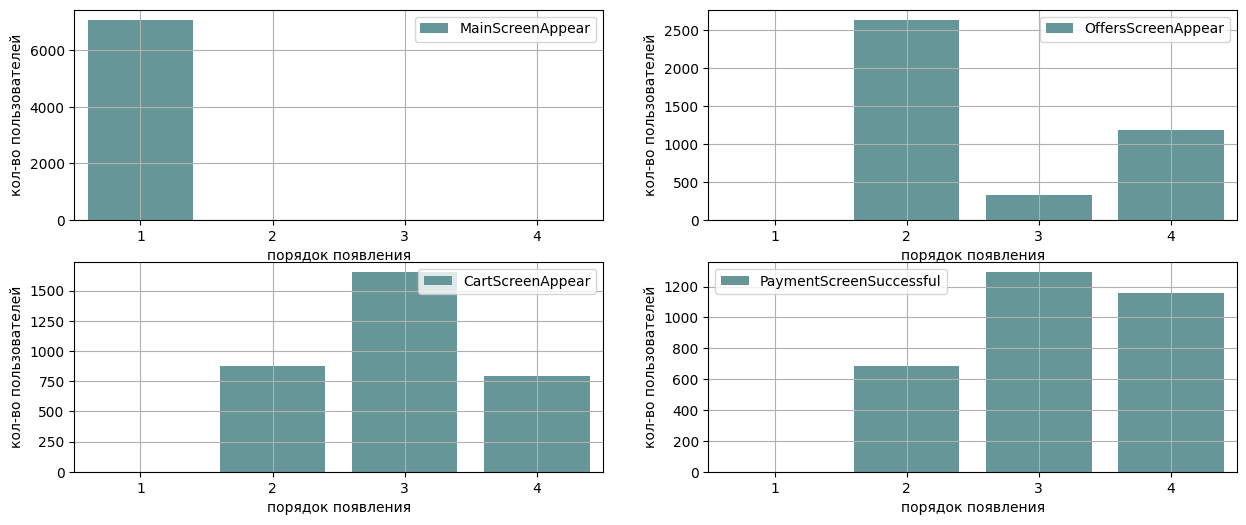

In [31]:
print()
print('   распределения событий по порядку их появления в логе для одного и того же пользователя', 
      '- убраны Tutorial и разорванные циклы')

plt.figure(figsize=(15, 6))

myax = [plt.subplot(2,2,1+i) for i in range(4)]

for i in range(4):
    sns.countplot(data=users_df.query('MainScreenAppear == 1.0'), # также выбросим циклы покупок, разорваные моментом начала 
                  x=types_list[i], order=[1,2,3,4], color='cadetblue', ax=myax[i], label=types_list[i] )

    myax[i].set_xlabel('порядок появления')
    myax[i].set_ylabel('кол-во пользователей')
    myax[i].legend()
    myax[i].grid()

plt.show()

**Анализ графика**:
1. `MainScreenAppear` теперь только на первом месте - мы выбросили небольшую часть разорванных циклов. 
2. `OffersScreenAppear` преимущественно на втором месте, однако может быть на третьем или четвертом месте - видимо, это в случае, когда куки сохранили корзину с выбором прошлой сессии, либо пользователь все время повторяет заказ (типично для продуктов - не выбирает, а идет в мои заказы и наживает "повторить заказ").  Существенное превышение четвертого места над третьим, возможно, означает, что после покупки сайт показывает страницу бонуса с выгодным предложением.
3. `CartScreenAppear` теперь явно показывает преференции на третье место, но может быть и на втором (вариант с куки, сохранившими корзину в виде "вы ранее заказывали"), и на четвертом.
4. `PaymentScreenSuccessful` приеимущественно оказывается и на третьем и на четвертом местах, видимо, из-за необязательности одного из предыдущих событий.  По логике покупки это всегда последний шаг воронки. 

#### Доля сценариев перехода от `MainScreenAppear`

In [32]:
print('Сценарий MainScreenAppear -> PaymentScreenSuccessful:')
share_main = round( 100 * len( users_df.query(
    'MainScreenAppear == 1.0 & PaymentScreenSuccessful == 2.0'
    ) ) / len( users_df.query('MainScreenAppear == 1.0') ), 2)
print(' доля конверсии пользователей =', share_main, '%')
print('------------------------------------------------------')

print('Сценарий MainScreenAppear -> OffersScreenAppear:')
share_offer = round( 100 * len( users_df.query(
    'MainScreenAppear == 1.0 & OffersScreenAppear == 2.0'
    ) ) / len( users_df.query('MainScreenAppear == 1.0') ), 2)
print(' доля конверсии пользователей =', share_offer, '%')
print('------------------------------------------------------')

print('Сценарий MainScreenAppear -> CartScreenAppear:')
share_cart = round( 100 * len( users_df.query(
    'MainScreenAppear == 1.0 & CartScreenAppear == 2.0'
    ) ) / len( users_df.query('MainScreenAppear == 1.0') ), 2)
print(' доля конверсии пользователей =', share_cart, '%')
print('------------------------------------------------------')

print('доля пользователей, не прошедших далее MainScreenAppear =', 
      round(100-share_main-share_offer-share_cart, 2), '%')
print('------------------------------------------------------')


Сценарий MainScreenAppear -> PaymentScreenSuccessful:
 доля конверсии пользователей = 9.7 %
------------------------------------------------------
Сценарий MainScreenAppear -> OffersScreenAppear:
 доля конверсии пользователей = 37.27 %
------------------------------------------------------
Сценарий MainScreenAppear -> CartScreenAppear:
 доля конверсии пользователей = 12.35 %
------------------------------------------------------
доля пользователей, не прошедших далее MainScreenAppear = 40.68 %
------------------------------------------------------


Таким образом, **вместо воронки имеем такую схему переходов**:

![Fig-01.0](https://disk.yandex.ru/i/F-ito9Gj7I9XkA) (если нет рисунка, выбрать в меню правой кнопки мыши "открыть изображение в новой вкладке")

![Fig-01.0bis](fig-01.png)

Поскольку идет замес сценариев с переходами между промежуточными стадиями `OffersScreenAppear` и `CartScreenAppear`, то сперва нужно посчитать в абсолютных величинах кол-во пользователей на каждом переходе, а потом принять соглашение по какой базе вычислять проценты конверсии.

In [33]:
print( 'Пользователей с первым событием MainScreenAppear:',
      len( users_df.query('MainScreenAppear == 1.0') ) )
print('------------------------------------------------------')

# ПЕРВЫЙ ШАГ КОНВЕРСИИ

print( 'Пользователей на переходе MainScreenAppear -> PaymentScreenSuccessful:',
      len( users_df.query('MainScreenAppear == 1.0 & PaymentScreenSuccessful == 2.0') ) )
print('------------------------------------------------------')

print( 'Пользователей на переходе MainScreenAppear -> OffersScreenAppear:',
      len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0') ) )
print('------------------------------------------------------')

print( 'Пользователей на переходе MainScreenAppear -> CartScreenAppear:',
      len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0') ) )
print('------------------------------------------------------')

# ВТОРОЙ ШАГ КОНВЕРСИИ

print( 'Пользователей на переходе MainScreenAppear -> OffersScreenAppear -> PaymentScreenSuccessful:',
      len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) )
print('------------------------------------------------------')

print( 'Пользователей на переходе MainScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful:',
      len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) )
print('------------------------------------------------------')

print( 'Пользователей на переходе MainScreenAppear -> OffersScreenAppear -> CartScreenAppear:',
      len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & CartScreenAppear == 3.0') ) )
print('------------------------------------------------------')

print( 'Пользователей на переходе MainScreenAppear -> CartScreenAppear -> OffersScreenAppear:',
      len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & OffersScreenAppear == 3.0') ) )
print('------------------------------------------------------')

# ТРЕТИЙ ШАГ КОНВЕРСИИ

print( 'Пользователей на переходе MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful:',
      len( users_df.query(
          'MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & CartScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') ) )
print('------------------------------------------------------')

print( 'Пользователей на переходе MainScreenAppear -> CartScreenAppear -> OffersScreenAppear -> PaymentScreenSuccessful:',
      len( users_df.query(
          'MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & OffersScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') ) )
print('------------------------------------------------------')

print( 'Пользователей с первым событием MainScreenAppear и достигших PaymentScreenSuccessful:',
      (
          len( users_df.query('MainScreenAppear == 1.0 & PaymentScreenSuccessful == 2.0') ) +
          len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) +
          len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) +
          len( users_df.query(
          'MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & CartScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') ) +
          len( users_df.query(
          'MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & OffersScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') )
      ) )
print('------------------------------------------------------')

Пользователей с первым событием MainScreenAppear: 7084
------------------------------------------------------
Пользователей на переходе MainScreenAppear -> PaymentScreenSuccessful: 687
------------------------------------------------------
Пользователей на переходе MainScreenAppear -> OffersScreenAppear: 2640
------------------------------------------------------
Пользователей на переходе MainScreenAppear -> CartScreenAppear: 875
------------------------------------------------------
Пользователей на переходе MainScreenAppear -> OffersScreenAppear -> PaymentScreenSuccessful: 780
------------------------------------------------------
Пользователей на переходе MainScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful: 516
------------------------------------------------------
Пользователей на переходе MainScreenAppear -> OffersScreenAppear -> CartScreenAppear: 988
------------------------------------------------------
Пользователей на переходе MainScreenAppear -> CartScreenAppear -

Отразим рассчитанные величины на нашей схеме:

#### Полная схема переходов пользователя между экранами:

![Fig-02.0](https://disk.yandex.ru/i/d27ln0iJa0SGzw) (если нет рисунка, выбрать в меню правой кнопки мыши "открыть изображение в новой вкладке")

![Fig-02.0bis](fig-02.png)

#### Расчет коэффициентов конверсии на каждом экране по схеме переходов межэу экранами

Несмотря на то, что мы не можем рассматривать экраны, как полноценные этапы воронки, которые в строгой последовательности проходит каждый пользователь, но мы все равно **можем определить коэффициент конверсии для каждого экрана как соотношение количества пользователей на выходе к количеству пользователей на входе** - эта величина также будет показывать, есть ли излишний отсев на данном экране.

In [34]:
cr_main = round(100 * ( 
    len( users_df.query('MainScreenAppear == 1.0 & PaymentScreenSuccessful == 2.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0') )
) / ( 
    len( users_df.query('MainScreenAppear == 1.0') ) 
), 2)

#----------------------------------------------------------------------------------------
cr_offers = round(100 * ( 
    len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & CartScreenAppear == 3.0') ) +
    len( users_df.query(
        'MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & OffersScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') )
) / ( 
    len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & OffersScreenAppear == 3.0') )
), 2)

#----------------------------------------------------------------------------------------
cr_cart = round(100 * ( 
    len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & OffersScreenAppear == 3.0') ) +
    len( users_df.query(
        'MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & CartScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') )
) / ( 
    len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & CartScreenAppear == 3.0') )
), 2)

#----------------------------------------------------------------------------------------
cr_total = round(100 * ( 
    len( users_df.query('MainScreenAppear == 1.0 & PaymentScreenSuccessful == 2.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) +
    len( users_df.query('MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & PaymentScreenSuccessful == 3.0') ) +
    len( users_df.query(
        'MainScreenAppear == 1.0 & OffersScreenAppear == 2.0 & CartScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') ) +
    len( users_df.query(
        'MainScreenAppear == 1.0 & CartScreenAppear == 2.0 & OffersScreenAppear == 3.0 & PaymentScreenSuccessful == 4.0') )
) / ( 
    len( users_df.query('MainScreenAppear == 1.0') ) 
), 2)

Для визуализации запишем в наш датафрейм `event_types_df`, общую конверсию запишем в последней строке

In [35]:
event_types_df['CR_sch_%'] = pd.Series([cr_main, cr_offers, cr_cart, np.NaN, np.NaN, cr_total])
event_types_df

,event_name,nof_event_types,avg_frequency_per_hour,nof_users,share_of_total_users_%,avg_events_per_user,CR_sch_%
0,MainScreenAppear,117328,710.6,7419,98.47,15.81,59.32
1,OffersScreenAppear,46333,280.6,4593,60.96,10.09,68.69
2,CartScreenAppear,42303,256.6,3734,49.56,11.33,92.49
3,PaymentScreenSuccessful,33918,205.7,3539,46.97,9.58,NaN
4,Tutorial,1005,6.1,840,11.15,1.20,NaN
5,AnyFromTheAboveListed,240887,1458.8,7534,100.00,31.97,44.30


Дополним для сравнения столбцом конверсий в модели воронки:

##### Финальный датасет `event_types_df`

In [36]:
event_types_df['CR_fnl_%'] = pd.Series([
    round( 100 * event_types_df.loc[1,'nof_users'] / event_types_df.loc[0,'nof_users'], 2), 
    round( 100 * event_types_df.loc[2,'nof_users'] / event_types_df.loc[1,'nof_users'], 2), 
    round( 100 * event_types_df.loc[3,'nof_users'] / event_types_df.loc[2,'nof_users'], 2), 
    np.NaN, 
    np.NaN, 
    round( 100 * event_types_df.loc[3,'nof_users'] / event_types_df.loc[0,'nof_users'], 2)])
event_types_df

,event_name,nof_event_types,avg_frequency_per_hour,nof_users,share_of_total_users_%,avg_events_per_user,CR_sch_%,CR_fnl_%
0,MainScreenAppear,117328,710.6,7419,98.47,15.81,59.32,61.91
1,OffersScreenAppear,46333,280.6,4593,60.96,10.09,68.69,81.30
2,CartScreenAppear,42303,256.6,3734,49.56,11.33,92.49,94.78
3,PaymentScreenSuccessful,33918,205.7,3539,46.97,9.58,NaN,NaN
4,Tutorial,1005,6.1,840,11.15,1.20,NaN,NaN
5,AnyFromTheAboveListed,240887,1458.8,7534,100.00,31.97,44.30,47.70


##### Выводы по коэффициентам конверсии
1. Оба метода дают отличающиеся значения - даже для полной конверсии.  Что объясняется тем, что в методе расчета по воронке мы учитываем всех пользователей - деже тех, кто начал с оплаты, а не с основного экрана.
2. Самое большое различие в оценке потерь на экране Offers - 12 процентных пункта, остальные коэффициенты конверсии отличаются в пределах 2.5 процентных пунктов с завышением у метода расчета по воронке.
3. Более точным мы считаем метод расчета по схеме, так как в нем учтен реальный порядок действий каждого пользователя.
4. Тем не менее сравнительные позиции коэффициентов конверсии одинаковы для обоих методов: CR_Cart > CR_Offers > CR_Main > CR_Total.
5. Коэффициенты конверсии не вызывают тревоги - совершенно естественно, что:
 * менее всего конверсия у начального экрана - пользователю может не понравится что-то с самого начала, или он зашел не имея намерений купить,
 * далее идет экран предложения - пользователю мог не понравится ассортимент или цены,
 * конверсия на экране корзины ожидаемо близка к единице - если уж пользователь собрал все в корзину и перешел в нее - то с намерением совершить покупку.  Однако и здесь может быть сбой со способом оплаты, или не устроить сроки доставки.

#### Визуализация простой воронки продаж
Простой воронкой назовем упрощенную модель, в которой продполагается, что все пользователи проходят экранные формы в указанном порядке:
1. MainScreenAppear,
2. OffersScreenAppear,
3. CartScreenAppear,
4. PaymentScreenSuccessful.

Хотя мы уже посчитали простую воронку в табличном виде (см. последний вывод датафрейма `event_types_df` чуть выше), покажем ее теперь также на графике.

Для схемы переходов нам пришлось вручную рисовать картинку с цифрами, так как нет такого сложного графика в известных нам библтотеках.  А вот для простой воронки мы можем воспользоваться графическим пакетом.  Однако, будем следовать настоятельным рекомендациям профессиональных аналитиков использовать не буквальную воронку типа "шапка Железного Дровосека", а упорядоченный слева-направо barplot для визуализации воронки.

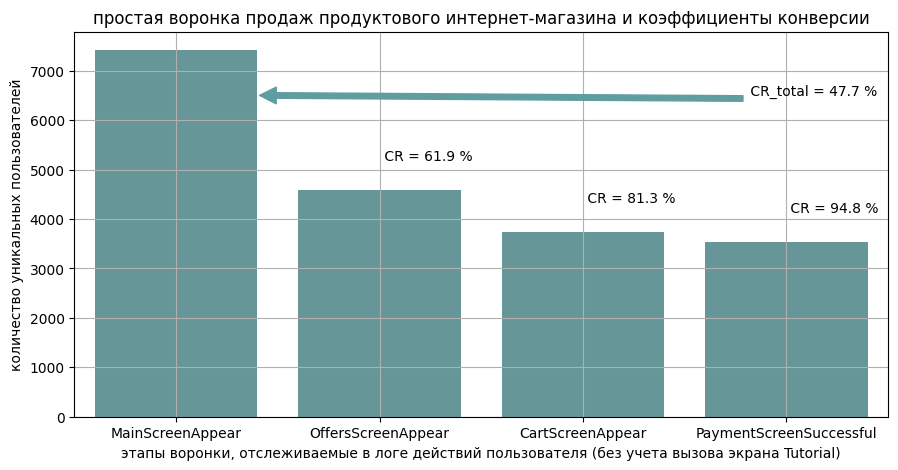

In [37]:
pres_df = events_df.query('event_name != "Tutorial"').groupby('event_name').agg({'uid':'nunique'})
order_list = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

plt.figure(figsize=(10.5, 5))

sns.barplot(x=pres_df.index, y=pres_df['uid'], color='cadetblue', order=order_list)

plt.title('простая воронка продаж продуктового интернет-магазина и коэффициенты конверсии')
plt.xlabel('этапы воронки, отслеживаемые в логе действий пользователя (без учета вызова экрана Tutorial)')
plt.ylabel('количество уникальных пользователей')
plt.grid()

for i in [1,2,3]:
    plt.annotate(text=' CR = '+str( round(100* pres_df.loc[order_list[i],'uid'] / pres_df.loc[order_list[i-1],'uid'], 1))+' %', 
                 xy=(i, pres_df.loc[order_list[i],'uid'] + 600) )
plt.annotate(text=' CR_total = '+str( round(100* pres_df.loc[order_list[3],'uid'] / pres_df.loc[order_list[0],'uid'], 1))+' %',
             xy=(0.41,6500), xytext=(2.8,6500), arrowprops=dict(color='cadetblue', shrink=0.0) )
plt.show()

## Анализ результатов A/A/B тестирования
**Дисклеймер**: Хотя в инструкциях по проекту программа данного раздела написана в произвольном порядке, в данном отчете данная глава написана в том логическом порядке следования действий, который и должен быть при анализе А/В теста.  При этом проведена проверка, что данная глава включила все задания соответствующего раздела инструкций - см.оглавление. 

### Цель и постановка задачи на А/А/В тестирование
Прежде чем начинать выполнять программу инструкций по проекту в данном разделе, следует дать строгое определение состава выполненных работ по проведению тестирования - включая:
1. Цель нововведения (изменения шрифтов),
2. Статистику каких параметров предполагалось сравнивать по результатам,
3. Достаточную степень статистической достоверности выводов,
4. Какую информацию собирали (следствие 2),
5. Критерий выделения групп (следствие всех пунктов).

#### Предоставленное описание А/А/В тестирования
Исходная информация содержит весьма туманное определение для проведенного А/А/В тестирования - дословно: "***Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше***".

Не определено:
1. что значит лучше - каков критерий улучшения?
2. чего испугались менеджеры - какая метрика пользователя может ухудшится по их ожиданиям?

Более того, даже в столь коротком описании тестирования уже присутствуют две разных задачи тестирования:
1. "какой шрифт лучше" подразумевает проверку гипотезы, что критерий (пока не известный) повысился на статистически значимую величину у группы В;
2. а вот "менеджеры испугались, что пользователям будет непривычно" подразумевает проверку гипотезы о статистической незначительности ухудшения какой-то метрики пользовательского поведения (опять же пока не известной) у группы В.  При этом целью введения шрифтов может быть что-то, не имеющее никакого отнощения к продажам, но, например, упрощающее поддержку или внесение изменений в SW-продукт, или скорость его работы и пр.

В итоге мы не можем исключить ни один из вариантов, но по счастью оба используют общую нулевую гипотезу для общего набора статистик.  

#### Возможные статистики, по которым может проводиться сравнение результатов тестирования
Поскольку мы находимся уже в конечной точке тестирования, то нам придется восстанавливать строгие определения в обратном порядке, руководствуясь предположением, что та входная информация, что мы видим, была результатом некогда данных четких формулировок постановки задач. 

Поскольку собранная информация предполагается достаточной для определения статистики всех параметров сравнения, то избранные параметры сравнения ограничены:
1. коэффициентом конверсии пользователей в покупатели (промежуточные CR помогают только определить на какой из этапов воронки сильнее/слабее действует новый фактор интерфейса пользователя),
2. частотой совершаемых покупок покупателями (или их числом за интервал тестирования, общий для всех групп),
3. удержанием в группах.

Причем удержание не лучший из параметров, так как срок слишком короткий - всего неделя, моловероятно, что за этот период можно покупать продукты чаще 2-3 раз.  Для сравнительного анализа по удержанию нужен существенно больший срок тестирования.

Хотя у нас отсутствует денежные характеристики (LTV, стоимость среднего чека, CAC, ROI), но характер внесенных в GUI изменений - смена шрифтов - предположительно, не может повлиять на таковые.  Хотя теоретически можно предположить, что влияние готического шрифта на подсознание покупателей привело к тому, что они стали закупаться реже, но с большим чеком, или наоборот.

#### Достаточная степень достоверности

##### Критерий достоверности оптимистичного сценария (улучшить)
Оптимистичность означает проверку явного улучшения статистик при переходе на новые шрифты. 
* $X_B$ лучше $X_A$ (больше или меньше в зависимости от смысла $X$),

при этом разумно взять обычное:
* при p_value < **alpha_opt = 0.05** (то есть в 95% случаев повторения аналогичного А/В тестирования)

##### Критерий достоверности консервативного сценария (не ухудшить)
Консервативность означает проверку не ухудшения статистик выше при переходе на новые шрифты.  Тестирование дает нам данные за неделю.  Магазин подводит результаты каждый месяц.  Финансовая отчетность годовая. Соответственно разумно взять:
* плохой год - если более 1 месяца в нем плохих
* плохой месяц - если более 1 недели в нем плохих
* вероятность плохой недели дает как раз недельный А/В тест:
 * после сравнения выборки $X_A$ и выборки $X_B$ выбранным далее статистическим тестом мы получим p_value для некой статистики $Z(X_A-X_B)$
 * вероятность плохой недели будет равна $p = {p\_value \over 2}$,
 * тогда вероятность плохого месяца составит $P = 1 - ( (1-p)^4 + 4p*(1-p)^3)$,
 * а вероятность плохого года будет $\Pi = 1 - ( (1-P)^{12} + 12P*(1-P)^{11} )$

За консервативный критерий достоверности поэтому выбираем $\Pi < 0.05%$, теперь нужно численно решить уравнения выше и на основании вероятности плохой недели получить alpha для критерия проверки гипотезы p_value < alpha.  Функции для нахождения корней уравнений есть в scipy.optimize: 

In [38]:
def my_f(p):
    
    def my_Pi(p):
        
        def my_P(p):
            return 1 - ( math.pow(1-p,4) + 4*p*math.pow(1-p,3) )
        
        return 1 - ( math.pow(1-my_P(p),12) + 12*p*math.pow(1-my_P(p),11) )
    
    return 0.05 - my_Pi(p) # здесь выбираем критерий достоверности для плохого года

p_bad_week = optimize.root_scalar(my_f, bracket=(0.0,1.0), x0=0.5).root

print('Вероятность плохого года меньше', 0.05 - my_f(p_bad_week), 
      'при вероятности плохой недели меньше', p_bad_week)

Вероятность плохого года меньше 0.049999999999990274 при вероятности плохой недели меньше 0.12839137823186228


Итак в результате статистического сравнения мы получим p_value, которое будет означать вероятность получить не меньшую разницу между средними $<X_A>$ и $<X_B>$ того же знака - при этом наша альтернативная гипотеза также односторонняя, поэтому: **alpha_cons = p_bad_week**.

##### Выводы по диапазонам значений `p_value` с принятой степенью достоверности
Оформим инструкции по выводам в виде таблицы:

| диапазон p_value | при этом $X_B$ vs $X_A$ | вывод оптимистичный из А/В тестов | вывод консервативный из А/В тестов |
|:----------------:|:-----------------------:|:----------------------------------|:-----------------------------------|
| p_value > alpha_cons | неважно | нельзя утверждать, что новые шрифты лучше | опасения менеджеров нельзя проверить |
| alpha_opt < p_value < alpha_cons | неважно | нельзя утверждать, что новые шрифты лучше | опасения менеджеров напрасны |
| p_value < alpha_cons | при этом $X_B$ лучше $X_A$ | новые шрифты лучше | опасения менеджеров напрасны |
| p_value < alpha_opt | при этом $X_B$ хуже $X_A$ | новые шрифты хуже  | опасения менеджеров верны |

где alpha_opt и alpha_cons равны соответственно:

In [39]:
alpha_opt = 0.05
alpha_cons = p_bad_week
print('alpha_opt =', alpha_opt)
print('alpha_cons =', round(alpha_cons,3))

alpha_opt = 0.05
alpha_cons = 0.128


#### Добавление статвеличин в датасет `users_df`
Согласно выводам выше и требованиям одинаковой активности групп нам нужно добавить следующие статистические величины, распределения которых мы будем сравнивать по статистическим критериям.  Поскольку датасет `users_df` уже содержит поле группы, то соответствующие выборки статвеличин будут получаться как `users_df.query('group == "X-24Y"')['статвеличина']`.

##### Конверсия в покупатели

In [40]:
users_df['CR'] = users_df['PaymentScreenSuccessful'].notna().astype('int')

##### Частота покупок в неделю

In [41]:
def line_f_count_events(s,type):
    count = 0
    for event in s:
        if event == type:
            count += 1
    return count

users_df['nof_payment'] = users_df['time_sorted_events'].apply(line_f_count_events, type='PaymentScreenSuccessful')

##### общая активность пользователя по посещению MainScreenAppear и других этапов воронки

In [42]:
users_df['nof_main'] = users_df['time_sorted_events'].apply(line_f_count_events, type='MainScreenAppear')
users_df['nof_offers'] = users_df['time_sorted_events'].apply(line_f_count_events, type='OffersScreenAppear')
users_df['nof_cart'] = users_df['time_sorted_events'].apply(line_f_count_events, type='CartScreenAppear')

##### Обновленный датасет `users_df`

In [43]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7534 entries, 0 to 7533
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uid                      7534 non-null   int64  
 1   time_sorted_events       7534 non-null   object 
 2   group                    7534 non-null   object 
 3   Tutorial                 840 non-null    float64
 4   MainScreenAppear         7419 non-null   float64
 5   OffersScreenAppear       4593 non-null   float64
 6   CartScreenAppear         3734 non-null   float64
 7   PaymentScreenSuccessful  3539 non-null   float64
 8   events_without_tutorial  7534 non-null   object 
 9   CR                       7534 non-null   int32  
 10  nof_payment              7534 non-null   int64  
 11  nof_main                 7534 non-null   int64  
 12  nof_offers               7534 non-null   int64  
 13  nof_cart                 7534 non-null   int64  
dtypes: float64(5), int32(1),

#### Выбор статистических критериев проверки нулевой гипотезы
Как обычно, $H_0$ - гипотеза о равенстве статвеличин в исходных популяциях. При этом у нас следующие статвеличены:
1. `user_activity_1w` - частота заходов на MainScreenAppear за неделю тестирования (столбец `nof_main`) - используется для проверки исходной равности всех групп. 
2. `user_CR_1w` - конверсия в покупатели за неделю тестирования (столбец `CR`) - используется для проверки влияния фактора между группами А и В, а также отсутствия такового для двух групп А.
3. `user_LTV_1w` - частота покупок (показа PaymentScreenSuccessful) за неделю тестирования (столбец `nof_payment`) - используется для проверки влияния фактора между группами А и В, а также отсутствия такового для двух групп А.

In [44]:
# посмотрим статистику этих величин
users_df[['nof_main','CR','nof_payment']].describe()

,nof_main,CR,nof_payment
count,7534.000000,7534.000000,7534.000000
mean,15.573135,0.469737,4.501991
std,16.050403,0.499116,25.623005
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,11.000000,0.000000,0.000000
75%,20.000000,1.000000,4.000000
max,205.000000,1.000000,1085.000000


До сих пор мы не уточняли, какое статистические критерии мы будем использовать для проверки нулевой гипотезы.  Причина в том, что нам придется использовать различные для разных распределений стат величины:
* `user_activity_1w` и `user_LTV_1w` - характеризуются длинными хвостами (помимо статистики выше см. также гистограмму в главе 4.2.1) и "ненормальностью" распределения, как многие статвеличины, порожденные неограниченной волей человека.  Для их сравнения уместнее использовать непараметрический **тест (Уилкоксона-)Манна-Уитни**.
* а вот `user_CR_1w` принимает всего два значения , и даже люди-Х не могут этого изменить.  По факту эту случайную величину для одного пользователя нельзя назвать CR, а собственно CR является производная случайная величина, равная доле "успешного" значения в случайной выборке.  Но у нас нет выборки из N элементов со средними долями, поэтому функции, сравнивающие выборки тут не подходят.  Для сравнения штучных значений долей в выборках из многих значений используется **z-тест**, который базируется на теореме, что при верной нулевой гипотезе статистика величины Z имеет нормальное распределение N(0,1):

$$ Z = {CR_1 - CR_2 \over \sqrt{CR*(1-CR)*(1/N_1+1/N_2)} }\ \ , $$
что позволяет определить **p_value**, зная $Z$.

#### Функции статистического сравнения результатов А/В тестирования - `compare_groups()`, `compare_LTV()` и `compare_CR`
* **`compare_groups() -`** используется для проверки статистической равности любых двух групп методом Манна-Уитни по количестку заходов одного пользователя на основной экран MainScreenAppear.  Параметры:
 * **df** - принимает датасет users_df,
 * **group1** - принимает id любой группы из ('A-246', 'A-247', 'B-248'),
 * **group2** - принимает id группы из ('A-246', 'A-247', 'B-248'), отличный от group1.
* **`compare_LTV()    -`** используется для проверки различия групп А и В методом Манна-Уитни по количеству сделанных покупок.  **NB!**: LTV считается только по покупателям! Параметры:
 * **df** - принимает датасет users_df,
 * **groupB** - принимает только значение 'B-248' (хотя для проверки отсутствия эффекта между двумя группами А может принять значение второй группы А, отличной от значения groupA),
 * **groupA** - всегда принимает id группы из ('A-246', 'A-247').
* **`compare_CR()     -`** используется для проверки различия групп А и В методом расчета Z-статистики по доле пользователей, ставших покупателями.  Параметры:
 * **df** - принимает датасет users_df,
 * **groupB** - принимает только значение 'B-248' (хотя для проверки отсутствия эффекта между двумя группами А может принять значение второй группы А, отличной от значения groupA),
 * **groupA** - всегда принимает id группы из ('A-246', 'A-247').
 
 Далее следует код самих функций:

In [45]:
# ----------------------------------------------------- определим вспомогательные функции, возвращающие p_value
def p_value_MWtest(df, group1, group2, nof_events):
    '''
    Функция получает выборки срезом датафрейма df по соответствующим группам 1 и 2, для столбца nof_events.
    Затем библиотечной функцией, реализующей метод Манна-Уитни, она находит p_value и возвращает его.
    '''
    sample1 = list(df.query('group == @group1')[nof_events])
    sample2 = list(df.query('group == @group2')[nof_events])
    return stats.mannwhitneyu(sample1, sample2).pvalue

def p_value_Ztest(df, group1, group2, share):
    '''
    Функция получает выборки срезом датафрейма df по соответствующим группам 1 и 2, для столбца share.
    Затем рассчитывает z_value, которое по ЦПТ имеет нормальное распределение. 
    Затем библиотечной функцией cdf() для нормального распределения находит p_value и возвращает его.
    '''
    sample1 = df.query('group == @group1')[share]
    sample2 = df.query('group == @group2')[share]
    combined = df.query('group == @group1 | group == @group2')[share]
    
    p1 = sample1.mean()
    p2 = sample2.mean()
    P = combined.mean()
    n1 = len(sample1)
    n2 = len(sample2)
    z_value = abs(p1-p2) / math.sqrt( P * (1-P) * ( 1/n1 + 1/n2 ) )
    
    return stats.norm(0,1).cdf(-z_value) # так как cdf - это интеграл вероятности от -бесконечности
    

# -------------------------------------------- определим еще одну вспомогательную функцию
def print_results_ABt(p_value, X_B, X_A):
    '''
    Функция реализует логику выбора выводов по А/В тестированию из таблицы главы 5.1.3.3
    '''
    if p_value > alpha_cons:
        print('нельзя утверждать, что новые шрифты лучше,',
              'а опасения менеджеров, что это снизит продажи, нельзя проверить.')
    elif p_value > alpha_opt:
        print('нельзя утверждать, что новые шрифты лучше,',
              'зато опасения менеджеров, что это снизит продажи, напрасны.')
    else:
        if X_B > X_A:
            print('новые шрифты действительно лучше,',
              'и опасения менеджеров, что это снизит продажи, напрасны.')
        elif X_B < X_A:
            print('новые шрифты однозначно хуже,',
              'и менеджеры были правы - это действительно снизит продажи.')
        else:
            print('этого просто не может быть!') # при p_value < 0.05 распредлеления должны различаться на более чем 1.98 сигма
            
#--------------------------------------------------------------------------------------
def compare_groups(df, group1, group2):
    p_value = p_value_MWtest(df, group1, group2, 'nof_main')
    print('При равной активности пользователей вероятность получить такую разницу между группами', 
          group1, 'и', group2, ':', p_value)

#--------------------------------------------------------------------------------------
def compare_LTV(df, groupB, groupA):
    df_only_buyers = df[ df['PaymentScreenSuccessful'].notna() ] # делаем срез только по покупателям 
    p_value = p_value_MWtest(df_only_buyers, groupB, groupA, 'nof_payment')
    LTV_B = df.query('group == @groupB')['nof_payment'].mean()
    LTV_A = df.query('group == @groupA')['nof_payment'].mean()
    
    # контрольный вывод:
    print('p_value =', p_value)
    print('Среднее LTV среди покупателей в группе В =', LTV_B)
    print('Среднее LTV среди покупателей в группе A =', LTV_A)
    
    # вывод по А/В тестированию
    print()
    print('Вывод по А/В тесту для LTV среди покупателей групп', groupB, 'и', groupA, ':')
    print_results_ABt(p_value, LTV_B, LTV_A)
    
#--------------------------------------------------------------------------------------
def compare_CR(df, groupB, groupA):
    p_value = p_value_Ztest(df, groupB, groupA, 'CR')
    CR_B = df.query('group == @groupB')['CR'].mean()
    CR_A = df.query('group == @groupA')['CR'].mean()
    
    # контрольный вывод:
    print('p_value =', p_value)
    print('Средний CR в группе В =', CR_B)
    print('Средний CR в группе A =', CR_A)
    
    # вывод по А/В тестированию
    print()
    print('Вывод по А/В тесту для CR среди групп', groupB, 'и', groupA, ':')
    print_results_ABt(p_value, CR_B, CR_A)

### Экспериментальные группы пользователей - создание датасета `groups_df`
Посмотрим количества пользователей в разных группах А/А/В тестирования - сразу будем заносить в общую таблицу групп и вести ее дальше:

In [46]:
groups_df = events_df.groupby('group',as_index=False).agg({'uid':'nunique'}).rename(columns={'uid':'nof_users'})
groups_df

,group,nof_users
0,A-246,2484
1,A-247,2513
2,B-248,2537


Также сразу добавим в эту таблицу средние значения статистик и оценку стандарных отклонений средних статистик от средних значений параметров популяций  (у нас сравниваются две популяции пользователей - с разными шрифтами в интерфейсе: старыми и новыми) - отличается от стандарных отклонений статистик в корень из кол-ва элементов в выборке раз.  Это позволит нам сразу заметить очевидные сручаи, когла средние отличаются более чем в 2-3 раза, чем квадратичная сумма стандартных отклонений (что при близосте долей к половине примерно соответствует стандартному отклонения статистики для разницы средних)  

In [47]:
groups_df['avg_CR'] = pd.Series(
    [ round(users_df.query('group == @s')['CR'].describe()['mean'], 2) for s in list(groups_df['group']) ])

groups_df['std_avg_CR'] = pd.Series(
    [ round(users_df.query('group == @s')['CR'].describe()['std'], 3) for s in list(groups_df['group']) ])
groups_df['std_avg_CR'] = round( groups_df['std_avg_CR'] / groups_df['nof_users'].apply(math.sqrt) , 2)

groups_df['avg_nof_payment'] = pd.Series(
    [ round(users_df.query('group == @s')['nof_payment'].describe()['mean'], 1) for s in list(groups_df['group']) ])

groups_df['std_avg_nof_payment'] = pd.Series(
    [ round(users_df.query('group == @s')['nof_payment'].describe()['std'], 2) for s in list(groups_df['group']) ])
groups_df['std_avg_nof_payment'] = round( groups_df['std_avg_nof_payment'] / groups_df['nof_users'].apply(math.sqrt) , 1)

groups_df['avg_nof_main'] = pd.Series(
    [ round(users_df.query('group == @s')['nof_main'].describe()['mean'], 1) for s in list(groups_df['group']) ])

groups_df['std_avg_nof_main'] = pd.Series(
    [ round(users_df.query('group == @s')['nof_main'].describe()['std'], 2) for s in list(groups_df['group']) ])
groups_df['std_avg_nof_main'] = round( groups_df['std_avg_nof_main'] / groups_df['nof_users'].apply(math.sqrt) , 1)

groups_df

,group,nof_users,avg_CR,std_avg_CR,avg_nof_payment,std_avg_nof_payment,avg_nof_main,std_avg_nof_main
0,A-246,2484,0.48,0.01,4.8,0.5,15.2,0.3
1,A-247,2513,0.46,0.01,4.0,0.4,15.6,0.3
2,B-248,2537,0.47,0.01,4.8,0.6,16.0,0.3


Увы, все разницы лежат в пределах суммы отклонений, поэтому простой критерий не поможет сразу указать, где есть явные различия - придется аккуратно считать статистические критерии и сравнивать с ранее определенной степенью достоверности.  Единственная пара выборок, которая отливается более чем на сумму стандартных отклонений:

In [48]:
groups_df.loc[ [0,2] , ['group','avg_nof_main','std_avg_nof_main'] ]

,group,avg_nof_main,std_avg_nof_main
0,A-246,15.2,0.3
2,B-248,16.0,0.3


Соответственно, их разница равна $0.8$, при ожидаемом стандартном отклонении для разницы порядка $0.3*\sqrt{2}=0.42$ - то есть, почти $2\sigma$ или порядка 0.05% вероятности получить такое отклонение при равных группах по данной случайной величине.  Но как раз по посещению основного экрана и измеряется одинаковость активности групп - то есть есть основания предполагать, что группа А-246 изначально не равнозначна группе В-248 (либо так стало при выбросе данных первой недели тестирования, как испорченных).  Поэтому А/В тест ожидается более точным при использовании группы А-247.

### Контрольный прогон функций статистического сравнения на группах А-246 и А-247 - А/А тест

#### Сравнение групп на исходное равенство

In [49]:
compare_groups(users_df, 'A-246', 'A-247')

При равной активности пользователей вероятность получить такую разницу между группами A-246 и A-247 : 0.715136465094412


##### Вывод:
Нет оснований считать группы разными по активности.  Группы А-246 и А-247 подобраны правильно между собой.

#### Сравнение LTV в группах
Так как этот тест не симметричен по формулировкам выводов при определенных p_value, то смотрим оба варианта распределения роли В-группы между двумя А-группами

In [50]:
compare_LTV(users_df, 'A-246', 'A-247')

p_value = 0.40626877170479914
Среднее LTV среди покупателей в группе В = 4.7713365539452495
Среднее LTV среди покупателей в группе A = 3.9717469160366097

Вывод по А/В тесту для LTV среди покупателей групп A-246 и A-247 :
нельзя утверждать, что новые шрифты лучше, а опасения менеджеров, что это снизит продажи, нельзя проверить.


In [51]:
compare_LTV(users_df, 'A-247', 'A-246')

p_value = 0.40626877170479914
Среднее LTV среди покупателей в группе В = 3.9717469160366097
Среднее LTV среди покупателей в группе A = 4.7713365539452495

Вывод по А/В тесту для LTV среди покупателей групп A-247 и A-246 :
нельзя утверждать, что новые шрифты лучше, а опасения менеджеров, что это снизит продажи, нельзя проверить.


##### Выводы:
* Между А-группами действительно не должно быть разницы.

#### Сравнение CR в группах
Аналогично смотрим два варианта для исполнителя роли В-группы:

In [52]:
compare_CR(users_df, 'A-246', 'A-247')

p_value = 0.05728339656570924
Средний CR в группе В = 0.4830917874396135
Средний CR в группе A = 0.46080382013529647

Вывод по А/В тесту для CR среди групп A-246 и A-247 :
нельзя утверждать, что новые шрифты лучше, зато опасения менеджеров, что это снизит продажи, напрасны.


In [53]:
compare_CR(users_df, 'A-247', 'A-246')

p_value = 0.05728339656570924
Средний CR в группе В = 0.46080382013529647
Средний CR в группе A = 0.4830917874396135

Вывод по А/В тесту для CR среди групп A-247 и A-246 :
нельзя утверждать, что новые шрифты лучше, зато опасения менеджеров, что это снизит продажи, напрасны.


##### Выводы:
* В этом тесте p_value попал между alpha_opt и alpha_cons, поэтому хотя по оптимистичному критерию нельзя сказать определенно в пользу наличия разницы, но зато по консервативному критерию уже можно определенно сказать, что ухудшений нет.
* В целом сравнение по двум статвеличинам LTV и CR, использующие разные критерии (Манна-Уитни для LTV и Z-ститистику для CR) привели нас к одному выводу - А-группы одинаковы в пределах статистической значимости А/В теста.
* Кроме того, мы проверили и наши функции - результат совпал с ожидаемым.

### Применение функций статистического сравнения для анализа эффекта в группе В - А/В тест

#### Проверка равенства групп А и В

In [54]:
compare_groups(users_df, 'B-248', 'A-246')

При равной активности пользователей вероятность получить такую разницу между группами B-248 и A-246 : 0.16028131787289301


In [55]:
compare_groups(users_df, 'B-248', 'A-247')

При равной активности пользователей вероятность получить такую разницу между группами B-248 и A-247 : 0.31016628389739787


##### Вывод:
Нет оснований считать группы А и В разными по активности.  Группы А-246 и А-247 равнозначны группе B-248, однако, как мы указывали уже при первом взгляде на статистику в группах (в главе 5.2), группа А-247 лучше соответствует группе В-248, чем группа А-246.

#### Проверка эффекта новых шрифтов на LTV

In [56]:
compare_LTV(users_df, 'B-248', 'A-246')

p_value = 0.566249038926276
Среднее LTV среди покупателей в группе В = 4.763500197083169
Среднее LTV среди покупателей в группе A = 4.7713365539452495

Вывод по А/В тесту для LTV среди покупателей групп B-248 и A-246 :
нельзя утверждать, что новые шрифты лучше, а опасения менеджеров, что это снизит продажи, нельзя проверить.


In [57]:
compare_LTV(users_df, 'B-248', 'A-247')

p_value = 0.15249518202656248
Среднее LTV среди покупателей в группе В = 4.763500197083169
Среднее LTV среди покупателей в группе A = 3.9717469160366097

Вывод по А/В тесту для LTV среди покупателей групп B-248 и A-247 :
нельзя утверждать, что новые шрифты лучше, а опасения менеджеров, что это снизит продажи, нельзя проверить.


##### Выводы:
Покупатели начинают хотеть кушать и покупают продукты одинаково часто, какие бы шрифты им не приходилось бы читать на ценниках

#### Проверка эффекта новых шрифтов на CR

In [58]:
compare_CR(users_df, 'B-248', 'A-246')

p_value = 0.10612766378488986
Средний CR в группе В = 0.46551044540796216
Средний CR в группе A = 0.4830917874396135

Вывод по А/В тесту для CR среди групп B-248 и A-246 :
нельзя утверждать, что новые шрифты лучше, зато опасения менеджеров, что это снизит продажи, напрасны.


In [59]:
compare_CR(users_df, 'B-248', 'A-247')

p_value = 0.3686707526901982
Средний CR в группе В = 0.46551044540796216
Средний CR в группе A = 0.46080382013529647

Вывод по А/В тесту для CR среди групп B-248 и A-247 :
нельзя утверждать, что новые шрифты лучше, а опасения менеджеров, что это снизит продажи, нельзя проверить.


##### Выводы:
* статистически значимых улучшений конверсии от новых шрифтов нет
* но при сравнении с одной из А групп удалось получить статистически значимый ответ на опасения менеджеров - итак новые шрифты не отпугнут новых покупателей, статистическая значимость этого утверждения на языке понятном менеджерам такова:
 * в году будет не более одного месяца в котором было бы более одной недели, с негативным эффектом в группе В.

### Дополнительная проверка равенства групп A-246 и A-247 на равенство

В принципе, анализ А/А/В теста уже завершен, но в инструкциях предлагалось также сравнить две группы А не только по самому частому событию (MainScreenAppear), что мы использовали для проверки равенства всех трех групп между собой в функции compare_groups(), но и по другим событиям воронки: OfferScreenAppear, CartScreenAppear и PaymentScreenSuccessful. (**NB!**: функция compare_LTV() тоже использовала подсчет PaymentScreen, но по срезу покупателей, а не всех пользователей)

Напишем соответствующую функцию и цикл по всем этапам воронки:

In [60]:
events_dict = {
        'nof_main' : 'MainScreenAppear',
        'nof_offers' : 'OffersScreenAppear',
        'nof_cart' : 'CartScreenAppear',
        'nof_payment' : 'PaymentScreenSuccessful'
    }

def compare_groups_by_event(df, group1, group2, event):
    p_value = p_value_MWtest(df, group1, group2, event)
    print('При равных группах вероятность получить такую разницу между', 
          group1, 'и', group2, 'по событию', events_dict[event], '=', round(p_value,4))
    
for event in events_dict.keys():
    compare_groups_by_event(users_df, 'A-246', 'A-247', event)

При равных группах вероятность получить такую разницу между A-246 и A-247 по событию MainScreenAppear = 0.7151
При равных группах вероятность получить такую разницу между A-246 и A-247 по событию OffersScreenAppear = 0.2705
При равных группах вероятность получить такую разницу между A-246 и A-247 по событию CartScreenAppear = 0.1636
При равных группах вероятность получить такую разницу между A-246 и A-247 по событию PaymentScreenSuccessful = 0.077


#### Выводы:
* Мы видим, что хотя изначально группы подбирались одинаковыми по активности (экран MainScreenAppear), по мере их продвижения по воронке даже между группами А-246 и А-247 накапливается статистическая значимость разницы - хотя количество элементов в выборках при этом уменьшается.
* Возможно, движение группы по воронке напоминает броуновское движение - хотя в нем нет конкретного направления, но расстояние между любыми близкими изначально частицами увеличивается со временем.
* При этом даже если мы "выровняли" группы у начального экрана, дальше они случайным образом начнут расходится. Чем болше у нас таких конверсий (чем запутаннее интерфейс пользователя, тем сложнее проводить А/В тест - желательно брать несколько групп В и А.

Проверим наши предположения на тех же тестах, включив группу В (по идее тестирования на нее влияет фактов интерфейса, меняющий продвижение группы по форонке, но заметно ли это на фоне броуновского блуждания групп по воронке вообще?):

In [61]:
for event in events_dict.keys():
    compare_groups_by_event(users_df, 'B-248', 'A-246', event)

При равных группах вероятность получить такую разницу между B-248 и A-246 по событию MainScreenAppear = 0.1603
При равных группах вероятность получить такую разницу между B-248 и A-246 по событию OffersScreenAppear = 0.2042
При равных группах вероятность получить такую разницу между B-248 и A-246 по событию CartScreenAppear = 0.3139
При равных группах вероятность получить такую разницу между B-248 и A-246 по событию PaymentScreenSuccessful = 0.3341


In [62]:
for event in events_dict.keys():
    compare_groups_by_event(users_df, 'B-248', 'A-247', event)

При равных группах вероятность получить такую разницу между B-248 и A-247 по событию MainScreenAppear = 0.3102
При равных группах вероятность получить такую разницу между B-248 и A-247 по событию OffersScreenAppear = 0.8743
При равных группах вероятность получить такую разницу между B-248 и A-247 по событию CartScreenAppear = 0.7002
При равных группах вероятность получить такую разницу между B-248 и A-247 по событию PaymentScreenSuccessful = 0.4217


#### Выводы:
* Характер "блужданий" по воронке явно изменился, однако заметь в этом какую-то систему для содержательных выводов трудно.  Заметим, что изначально (у первого экрана) А-группы лучше выровнены друг с другом, чем с группой В.  Однако на последующих этапах выравнивание с группой В становится лучше, чем между двумя группами А.

## Выводы и рекомендации
1. Нет статистически значимых подтверждений, что новые шрифты лучше старых с достоверностью 95%.
2. На опасения менеджеров, что новые шрифты могут отпугнуть пользователей, при сравнении с одной из А групп получен статистически значимый результат, согласно которому можно утверждать, что негативное влияние не проявит себя чаще, чем: с достоверностью 95% в году будет не больше одного месяца, в котором было бы более одной недели с негативным влиянием новых шрифтов на конверсию пользователей в покупатели.

**Поэтому мы рекомендуем**:
1. Если новые шрифты вводятся для снижения затрат в обслуживании продукта, их можно вводить по результатам проведенного А/В тестирования без опасений негативного влияния на конверсию пользователей.
2. Если маркетинг питает надежды, что новые шрифты улучшат пользовательский опыт настолько, что это повлияет на продажи, то А/В тестирование следует продолжить с рассмотрением возможности учета следующих замечаний к текущему:
 * по каким-то причинам в исходных данных отсутствует половина периода тестирования,
 * изначальное выравнивание групп А и В хуже, чем выравнивание групп А между собой,
 * нет точной формулировки от продуктового маркетинга, что именно ожидается к улучшению - поэтому трудно определить достаточность собираемых данных и правильность методики их измерения.  Отсутствие данных за первую неделю косвенно указывает на проблемы с такой методикой. 

# <<<  КОНЕЦ ДОКУМЕНТА  >>>

In [63]:
stop_run = dt.datetime.now() # измеряем время выполнения команды run-all-cells
print('If you see this line, then run-all-cells command has been executed successfully!')
print('Full execution time was', round((stop_run-start_run).total_seconds(),2),'seconds. ',
     'The last run-through of this Notebook was on', stop_run.date(), 'at', str(stop_run.time()).split('.')[0] )

If you see this line, then run-all-cells command has been executed successfully!
Full execution time was 25.56 seconds.  The last run-through of this Notebook was on 2022-09-12 at 22:04:42
